In [1]:
import math
import random
import numpy as np
from itertools import product

from qiskit import *

# Importing standard Qiskit libraries
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.providers.aer import QasmSimulator

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

from qiskit.utils import QuantumInstance

from qiskit.opflow import I, X, Y, Z
from qiskit.opflow import StateFn
from qiskit.opflow import Gradient
from qiskit.opflow import CircuitSampler
from qiskit.opflow.primitive_ops import MatrixOp

from qiskit.circuit import Parameter
from qiskit.circuit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import RealAmplitudes

from qiskit.algorithms.optimizers import SPSA
from qiskit.algorithms.optimizers import COBYLA
from qiskit.algorithms.optimizers import GradientDescent
from qiskit.algorithms.optimizers import ADAM

from qiskit.providers.aer.noise import NoiseModel

from qiskit.quantum_info import Statevector
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter

In [2]:
provider = IBMQ.load_account()

In [3]:
def rand_numb(low_in,high_in):
    '''
    Returns a random number between low_in and high_in, including both end points.
    '''
    return np.random.uniform(low=low_in, high=np.nextafter(high_in, np.inf))

In [4]:
'''
Define variables for the number of layers and qubits of the prover. Define global variables used in the optimization.
'''
numLayer = 4
numQubit = 2
global iterations
global noisy

In [5]:
def createProver(numQubit, numLayer):
    '''
    Creates a parameterized unitary on numQubit qubits. Applies numLayer layers of the HEA with 2 Qiskit.parameters 
    per qubit per layer, specifying rotations about the x- and y-axes. After each layer, applies a neighbouring qubit
    CNOT layer. Returns a QuantumCircuit object containing the parameterized prover. 
    '''
    numparam = numQubit*numLayer*2
    prover = QuantumCircuit(numQubit)
    param_vector = ParameterVector("params", numparam)
    
    for j in range(numLayer):
        for i in range(numQubit):
            prover.rx(param_vector[j*2*numQubit + i], i)
            prover.ry(param_vector[j*2*numQubit + i + numQubit], i)

        for i in range(numQubit-1):
            prover.cx(i, i+1)
            
    return prover

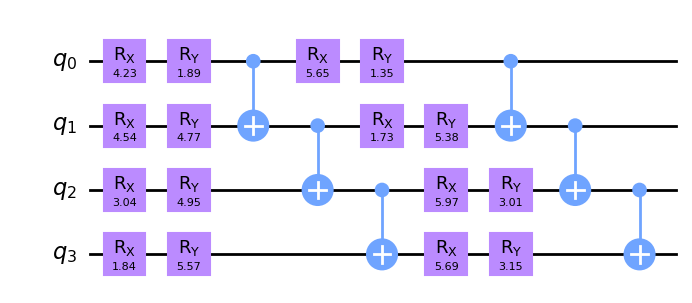

In [7]:
'''
Defines parameters that specify the purification of state to be tested. Create a QuantumCircuit object that
creates the purification on (size) number of qubits.
'''
unitary_param_1 = np.array([])
size = 4
layers = 2

for i in range(0, 2*size*layers):
    unitary_param_1 = np.append(unitary_param_1, np.array([rand_numb(0,2*np.pi)]))

state = QuantumCircuit(size)
for j in range(layers):
    for i in range(size):
        state.rx(unitary_param_1[j*size*2 + i], i)
        state.ry(unitary_param_1[j*2*size + i + size], i)

    for i in range(size-1):
        state.cx(i, i+1)

state.draw('mpl')

In [8]:
def createEqSuperposDihedral():
    '''
    Defines a quantum circuit to create the uniform superposition of basis elements required.
    '''
    temp = QuantumCircuit(3)
    temp.ry(2*np.arctan(1/np.sqrt(2)), 0)
    temp.x(0)
    temp.ch(0, 1)
    temp.x(0)
    temp.h(2)
    return temp

In [10]:
def createQuantumCircuit(state, numQubit, numLayer):
    '''
    Creates quantum circuit for the problem. 
    Refer to Section 3.B from https://arxiv.org/pdf/2105.12758
    The ciruit contains 7 qubits each labelled as (C, S, S')
    '''
    circ = QuantumCircuit(7)
    
    superPosCircuit = createEqSuperposDihedral()
    circ.append(superPosCircuit, [0, 1, 2])

    circ.append(state, [3, 4, 5, 6])
    
    prover = createProver(numQubit, numLayer)
    circ.append(prover, [5, 6])
    
    circ.ccx(2, 4, 3)
    circ.ccx(2, 6, 5)
    
    circ.cswap(1, 3, 4)
    circ.cswap(1, 5, 6)
    
    circ.ccx(0, 3, 4)
    circ.ccx(0, 5, 6)
    
    circ.append(superPosCircuit.inverse(), [0, 1, 2])
    
    return circ

In [10]:
'''
Creates the quantum circuit
'''
qCirc = createQuantumCircuit(state, numQubit, numLayer)
qCirc.draw('mpl')

NameError: name 'createQuantumCircuit' is not defined

In [11]:
'''
List of parameters of the quantum circuit.
'''
print(qCirc.parameters)

NameError: name 'qCirc' is not defined

In [12]:
'''
Pick a backend to use. We use the statevector_simulator for noiseless simulation.
'''
noiseless_backend = Aer.get_backend('statevector_simulator')
noiseless_q_instance = QuantumInstance(noiseless_backend)
noiseless_sampler = CircuitSampler(noiseless_q_instance)

In [13]:
'''
Pick a backend to use. We use the qasm_simulator for noisy simulation.
'''
provider = IBMQ.get_provider(hub="ibm-q-research", group="louisiana-st-uni-1", project="main")
noisy_backend = Aer.get_backend("qasm_simulator")
device = provider.get_backend("ibmq_jakarta")
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device.properties())
noisy_q_instance = QuantumInstance(backend=noisy_backend, 
                           shots=8192, 
                           noise_model=noise_model, 
                           coupling_map=coupling_map,
                           measurement_error_mitigation_cls=CompleteMeasFitter,
                           cals_matrix_refresh_period=30)
noisy_sampler = CircuitSampler(noisy_q_instance)

In [14]:
def costf(params):
    '''
    Assigns the params input to the parameters of the ansatz, and calculates the expectation value.
    '''
    expectation = StateFn(hamiltonian, is_measurement=True).compose(StateFn(qCirc))
    value_dict = dict(zip(qCirc.parameters, params))
    
    if noisy:
        result = noisy_sampler.convert(expectation, params=value_dict).eval()  
    else:
        result = noiseless_sampler.convert(expectation, params=value_dict).eval()  
    
    return -1*np.real(result)

In [15]:
def gradient(params):
    '''
    Assigns the params input to the parameters of the ansatz, and calculates the gradient value.
    '''
    expectation = StateFn(hamiltonian, is_measurement=True).compose(StateFn(qCirc))
    value_dict = dict(zip(qCirc.parameters, params))
    gradient = Gradient().convert(expectation)
    
    if noisy:
        result = noisy_sampler.convert(gradient, params=value_dict).eval()  
    else:
        result = noiseless_sampler.convert(gradient, params=value_dict).eval()  
    
    return -1*np.real(result)

In [16]:
def autospsa_callback(nfev, x, fx, stepsize, accepted = False):
    '''
    Callback function called automatically during optimization. Appends loss value, current iteration and 
    prints every iteration with a completion percentage.
    '''
    if (noisy == True):
        noisy_loss.append(-1*fx)
    else:
        noiseless_loss.append(-1*fx)
    print("Loss Value : ", -1*fx, str(nfev/3)+"%")

In [17]:
'''
Average value of this hamiltonian is the probability of measuring 0 on the first three qubit.
MatrixOp(np.array([[1, 0], [0, 0])) is the projector on the 0 subspace. Qiskit orders qubits in reverse.
'''
hamiltonian = I^I^I^I^MatrixOp(np.array([[1, 0], [0, 0]]))^MatrixOp(np.array([[1, 0], [0, 0]]))^MatrixOp(np.array([[1, 0], [0, 0]]))

In [18]:
'''
Initialize prover parameters to random angles
'''
numParam = 2*numQubit*numLayer
noisy = False
paramProver = []
for i in range(0, numParam):
    paramProver = np.append(paramProver, np.array([rand_numb(0,2*np.pi)]))
print(paramProver)

print("Initial Cost : ", -1*costf(paramProver))

[2.46680178 6.20802905 1.32279227 1.26837821 3.05003389 2.91351481
 3.38989789 5.58618413 3.63741698 2.63505645 0.04325302 0.05223526
 3.29680683 2.44598817 5.76685489 3.41259299]


NameError: name 'qCirc' is not defined

In [19]:
'''
True value calculated using the SDP.
'''
true_value = 1.0

In [75]:
'''
Perform the noiseless optimization using the SPSA algorithm for 200 iterations.
'''
noisy = False
noiseless_loss = []
noiselessParam = np.copy(paramProver)
print("Initial Cost : ", -1*costf(noiselessParam))
autospsa = SPSA(maxiter=200, learning_rate=None, perturbation=None, callback=autospsa_callback)
x_opt, fx_opt, nfevs = autospsa.optimize(numParam, costf, initial_point=noiselessParam)

Initial Cost :  0.5537164718571056
Loss Value :  0.551864779989593 1.0%
Loss Value :  0.7350045373505899 2.0%
Loss Value :  0.7451564705680201 3.0%
Loss Value :  0.762569506482133 4.0%
Loss Value :  0.8037845881513711 5.0%
Loss Value :  0.8196746220709296 6.0%
Loss Value :  0.8186711637295423 7.0%
Loss Value :  0.8294320011009831 8.0%
Loss Value :  0.8330166323640514 9.0%
Loss Value :  0.8345656144203899 10.0%
Loss Value :  0.884705429771876 11.0%
Loss Value :  0.9042216025257062 12.0%
Loss Value :  0.904798742986558 13.0%
Loss Value :  0.9115561167984805 14.0%
Loss Value :  0.9213076497277501 15.0%
Loss Value :  0.9242370378576121 16.0%
Loss Value :  0.9241464832711838 17.0%
Loss Value :  0.9778036088822711 18.0%
Loss Value :  0.9823283421208989 19.0%
Loss Value :  0.985053892179103 20.0%
Loss Value :  0.9854581752333693 21.0%
Loss Value :  0.9910541370855541 22.0%
Loss Value :  0.9911169269203539 23.0%
Loss Value :  0.9911238816526211 24.0%
Loss Value :  0.9914105449233622 25.0%
Loss

In [76]:
'''
Perform the noisy optimization using the SPSA algorithm for 200 iterations.
'''
noisy = True
noisy_loss = []
noisyParam = np.copy(paramProver)
-1*costf(noisyParam)
print("Initial Cost : ", -1*costf(noisyParam))
autospsa = SPSA(maxiter=200, learning_rate=None, perturbation=None, callback=autospsa_callback)
x_opt, fx_opt, nfevs = autospsa.optimize(numParam, costf, initial_point=noisyParam)

Initial Cost :  0.431601968609507
Loss Value :  0.4670876210882151 1.0%
Loss Value :  0.5976317388427297 2.0%
Loss Value :  0.5033412041140436 3.0%
Loss Value :  0.6349859919802916 4.0%
Loss Value :  0.6183210648988143 5.0%
Loss Value :  0.5487658302267402 6.0%
Loss Value :  0.5680124593953728 7.0%
Loss Value :  0.5614303225250563 8.0%
Loss Value :  0.5523303698059235 9.0%
Loss Value :  0.5504979648319688 10.0%
Loss Value :  0.6601383897964627 11.0%
Loss Value :  0.615825455969025 12.0%
Loss Value :  0.678609539510642 13.0%
Loss Value :  0.510946460183711 14.0%
Loss Value :  0.5262500011110645 15.0%
Loss Value :  0.5175940955083278 16.0%
Loss Value :  0.5034829167111242 17.0%
Loss Value :  0.5813873745484468 18.0%
Loss Value :  0.6604168711229161 19.0%
Loss Value :  0.5996615119722323 20.0%
Loss Value :  0.6080738391750172 21.0%
Loss Value :  0.531273252068604 22.0%
Loss Value :  0.5321895359829296 23.0%
Loss Value :  0.5578704601257306 24.0%
Loss Value :  0.5910679533402707 25.0%
Loss

In [20]:
'''
Evaluate the noiseless cost function using the parameters learned from the noisy optimization. 
'''
noisy = False
noiseResilientValue = -1*costf(x_opt)
print(noiseResilientValue)

NameError: name 'x_opt' is not defined

In [21]:
'''
Print all final values after training.
'''
print("True Value : ", true_value)
print("Noiseless : ", noiseless_loss[-1])
print("Noisy : ", noisy_loss[-1])
print("Noise Resilient Value : ", noiseResilientValue)

True Value :  1.0


NameError: name 'noiseless_loss' is not defined

In [61]:
def writeToFile():
    '''
    Write the training data to a text file to be used to plot the data. The format is as follows:
        True Value
        Noise Resilient Value
        Size of noiseless data list
        [
        Noiseless data with one entry per line
        ]
        Size of noisy data list
        [
        Noisy data with one entry per line
        ]
    '''
    file = open("Dihedral_GS.txt", "w+")
    file.write(str(true_value)+"\n")
    file.write(str(noiseResilientValue)+"\n")

    file.write(str(len(noiseless_loss))+"\n")
    L = [str(i)+"\n" for i in noiseless_loss]
    file.writelines(L)
    
    file.write(str(len(noisy_loss))+"\n")
    L = [str(i)+"\n" for i in noisy_loss[0:len(noisy_loss)-1]]
    file.writelines(L)
    
    file.write(str(noisy_loss[-1]))
    
    file.close()

In [62]:
writeToFile()